# Creating and Backtesting SMA/EMA Crossovers

## Creating the SMAEMABacktester Class (based on EMABacktester)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [ ]:
# make the necessary changes!

class EMABacktester(): 
    ''' Class for the vectorized backtesting of EMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    EMA_S: int
        time window in days for shorter EMA
    EMA_L: int
        time window in days for longer EMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new EMA parameters
        
    test_strategy:
        runs the backtest for the EMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates EMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two EMA parameters
    '''
    
    def __init__(self, symbol, EMA_S, EMA_L, start, end, tc):
        self.symbol = symbol
        self.EMA_S = EMA_S
        self.EMA_L = EMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "EMABacktester(symbol = {}, EMA_S = {}, EMA_L = {}, start = {}, end = {})".format(self.symbol, self.EMA_S, self.EMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("forex_pairs.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["EMA_S"] = raw["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        raw["EMA_L"] = raw["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean() 
        self.data = raw
        
    def set_parameters(self, EMA_S = None, EMA_L = None):
        ''' Updates EMA parameters and resp. time series.
        '''
        if EMA_S is not None:
            self.EMA_S = EMA_S
            self.data["EMA_S"] = self.data["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        if EMA_L is not None:
            self.EMA_L = EMA_L
            self.data["EMA_L"] = self.data["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["EMA_S"] > data["EMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | EMA_S = {} | EMA_L = {} | TC = {}".format(self.symbol, self.EMA_S, self.EMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, EMA):
        ''' Updates EMA parameters and returns the negative absolute performance (for minimazation algorithm).

        Parameters
        ==========
        EMA: tuple
            EMA parameter tuple
        '''
        self.set_parameters(int(EMA[0]), int(EMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, EMA1_range, EMA2_range):
        ''' Finds global maximum given the EMA parameter ranges.

        Parameters
        ==========
        EMA1_range, EMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (EMA1_range, EMA2_range), finish=None)
        return opt, -self.update_and_run(opt)
    
    

## Using the SMAEMABacktester Class

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [2]:
from SMAEMABacktester import SMAEMABacktester as SMAEMA

In [4]:
pd.read_csv("../original/forex_pairs.csv")

,Date,AUDEUR=X,EURUSD=X,USDGBP=X
0,2004-01-01,0.59780,1.258194,0.56016
1,2004-01-02,0.60314,1.258194,0.55751
2,2004-01-05,0.60467,1.268698,0.55334
3,2004-01-06,0.60350,1.272103,0.54906
4,2004-01-07,0.60728,1.264095,0.55012
...,...,...,...,...
4290,2020-06-24,0.61349,1.131235,0.79841
4291,2020-06-25,0.60938,1.125087,0.80561
4292,2020-06-26,0.61373,1.122208,0.80480
4293,2020-06-29,0.61128,1.122586,0.81023


__EUR / USD__

In [5]:
ptc = 0.00007

In [6]:
tester = SMAEMA("EURUSD=X", 50, 50, "2004-01-01", "2020-06-30", ptc)
tester

SMAEMABacktester(symbol = EURUSD=X, SMA = 50, EMA = 50, start = 2004-01-01, end = 2020-06-30)

In [7]:
tester.data

,price,returns,SMA,EMA
Date,,,,
2004-01-01,1.258194,NaN,NaN,NaN
2004-01-02,1.258194,0.000000,NaN,NaN
2004-01-05,1.268698,0.008313,NaN,NaN
2004-01-06,1.272103,0.002681,NaN,NaN
2004-01-07,1.264095,-0.006315,NaN,NaN
...,...,...,...,...
2020-06-24,1.131235,0.002892,1.101794,1.109674
2020-06-25,1.125087,-0.005449,1.102486,1.110279
2020-06-26,1.122208,-0.002562,1.103213,1.110746


In [8]:
tester.test_strategy()

(1.157402, 0.237909)

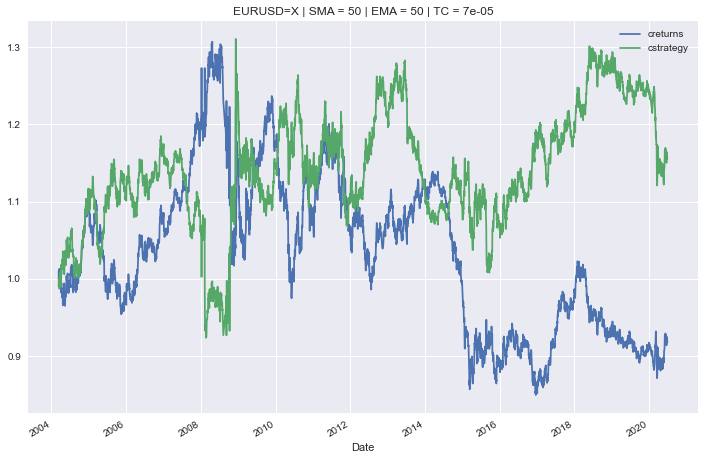

In [9]:
tester.plot_results()

In [10]:
tester.optimize_parameters((20, 100, 1), (20, 100, 1))

(array([43., 36.]), 1.924355)

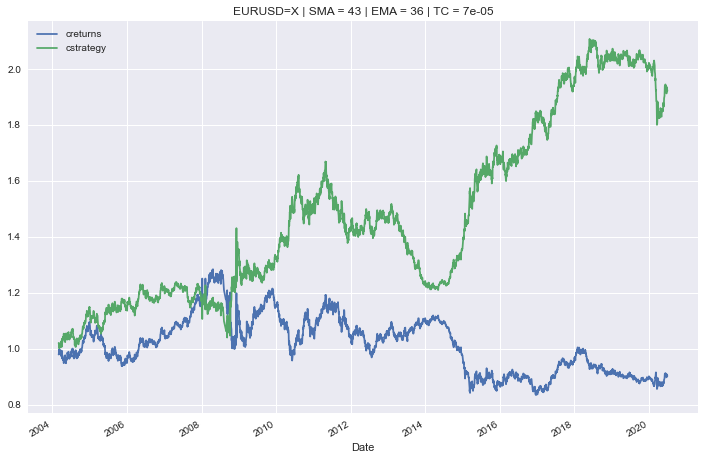

In [11]:
tester.plot_results()

In [12]:
tester.results

,price,returns,SMA,EMA,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2004-03-02,1.220405,-0.019794,1.261210,1.258758,-1,0.019794,0.0,0.980400,1.019992
2004-03-03,1.219096,-0.001073,1.260301,1.256422,-1,0.001073,0.0,0.979349,1.021087
2004-03-04,1.220703,0.001317,1.259185,1.254329,-1,-0.001317,0.0,0.980640,1.019743
2004-03-05,1.236797,0.013098,1.258364,1.253306,-1,-0.013098,0.0,0.993569,1.006473
2004-03-08,1.242607,0.004686,1.257864,1.252685,-1,-0.004686,0.0,0.998236,1.001768
...,...,...,...,...,...,...,...,...,...
2020-06-24,1.131235,0.002892,1.104555,1.113598,1,0.002892,0.0,0.908766,1.935501
2020-06-25,1.125087,-0.005449,1.105548,1.114219,1,-0.005449,0.0,0.903828,1.924983
2020-06-26,1.122208,-0.002562,1.106472,1.114651,1,-0.002562,0.0,0.901515,1.920058


__AUD / EUR__

In [13]:
tester = SMAEMA("AUDEUR=X", 50, 50, "2004-01-01", "2020-06-30", 0)

In [14]:
tester.test_strategy()

(1.049912, 0.053484)

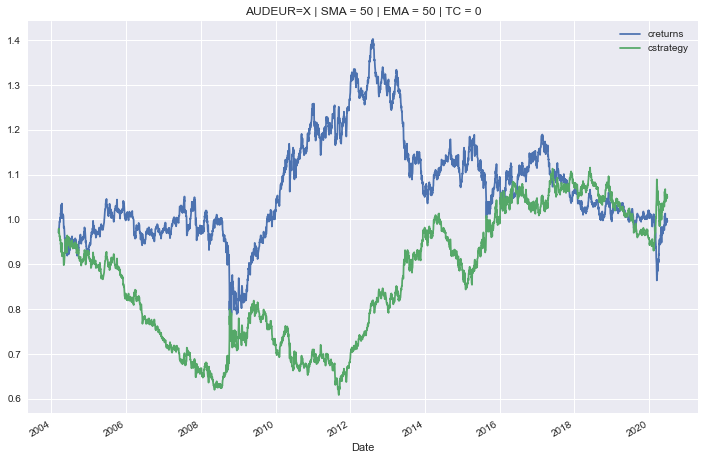

In [15]:
tester.plot_results()

In [16]:
tester.optimize_parameters((20, 100, 1), (20, 100, 1))

(array([26., 37.]), 2.837084)

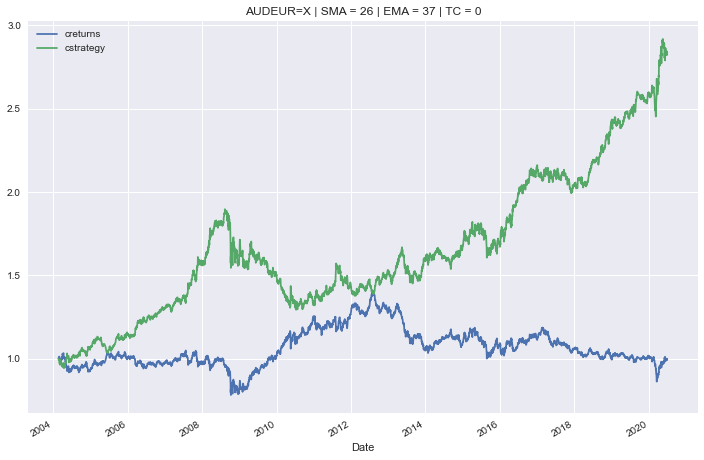

In [17]:
tester.plot_results()